> **Minnesota is a season champion. What made them stand out? What wins the championship**:
> - Team effort or star effort
> - Offensive or defensive effort

In [1]:
# Libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
from scipy import stats
from scipy.stats import ttest_1samp
pd.set_option('max_columns', 50)

In [2]:
wnba = pd.read_csv('wnba_clean.csv')

In [3]:
wnba.head()

Name Team  Pos  Height  Weight        BMI Birth_Place  \
0    Aerial Powers  DAL    F     183      71  21.200991          US   
1      Alana Beard   LA  G/F     185      73  21.329438          US   
2     Alex Bentley  CON    G     170      69  23.875433          US   
3  Alex Montgomery  SAN  G/F     185      84  24.543462          US   
4     Alexis Jones  MIN    G     175      78  25.469388          US   

           Birthdate  Age         College Experience  Games Played  MIN  FGM  \
0   January 17, 1994   23  Michigan State          2             8  173   30   
1       May 14, 1982   35            Duke         12            30  947   90   
2   October 27, 1990   26      Penn State          4            26  617   82   
3  December 11, 1988   28    Georgia Tech          6            31  721   75   
4     August 5, 1994   23          Baylor          R            24  137   16   

   FGA   FG%  3PM  3PA   3P%  FTM  FTA   FT%  OREB  DREB  REB  AST  STL  BLK  \
0   85  35.3   12   32  37.5   21   26  80.8     6    22   28   12    3    6   
1  177  50.8    5   18  27.8   32   41  78.0    19    82  101   72   63   13   
2  218  37.6   19   64  29.7   35   42  83.3     4    36   40   78   22    3   
3  195  38.5   21   68  30.9   17   21  81.0    35   134  169   65   20   10   
4   50  32.0    7   20  35.0   11   12  91.7     3     9   12   12    7    0   

   TO  PTS  DD2  TD3  
0  12   93    0    0  
1  40  217    0    0  
2  24  218    0    0  
3  38  188    2    0  
4  14   50    0    0

In [4]:
wnba_points = wnba.groupby(['Team', 'Name'])['PTS'].sum().reset_index()

teams = wnba['Team'].unique()

wnba['OREB_v_DREB'] = wnba['OREB'] / wnba['DREB']

In [5]:
#EFF: efficiency: NBA's efficiency rating: (PTS + REB + AST + STL + BLK − ((FGA − FGM) + (FTA − FTM) + TO))
wnba["Player Efficiency"] = wnba['PTS'] + wnba['REB'] + wnba['AST'] + wnba['STL'] + wnba['BLK'] - ((wnba['FGA'] - wnba['FGM']) + (wnba['FTA'] - wnba['FTM']) + wnba['TO'])

wnba["Player Efficiency per 36"] = wnba["Player Efficiency"]/wnba['MIN']*36

wnba['Minutes played by player per game'] =  wnba['MIN']/wnba['Games Played']

wnba['Experience of a player'] = wnba['Experience'].replace('R', 0)

wnba['Experience of a player'] = wnba['Experience of a player'].astype(int)

wnba['Experience normalised'] = wnba['Experience of a player']/wnba['Experience of a player'].groupby(wnba['Team']).transform('max')

wnba['PTS_percent'] = wnba['PTS']/wnba['PTS'].groupby(wnba['Team']).transform('sum')

wnba = wnba.sort_values(by = ['Team', 'PTS_percent'], ascending = [False, False])

wnba['Cumulative share of points scored'] =  wnba['PTS_percent'].groupby(wnba['Team']).transform('cumsum')

wnba['Cumulative number of players'] =  wnba.groupby('Team').cumcount()+1

wnba['Season_winner'] = wnba['Team'] == 'MIN'

In [39]:
lst = wnba.sort_values(by = ["Player Efficiency per 36"], ascending = False).head(25).groupby('Team')['Player Efficiency per 36'].agg('mean')

lst.sort_values(ascending = False)

Team
LA     26.606413
MIN    26.042935
PHO    25.223026
NY     25.207808
CHI    21.848602
SEA    21.367450
CON    20.344538
DAL    20.030955
ATL    19.636364
WAS    19.406137
Name: Player Efficiency per 36, dtype: float64

In [38]:
lst2 = wnba.sort_values(by = ["Player Efficiency per 36"], ascending = False).head(25).groupby('Team')['Player Efficiency per 36'].count()
lst2.sort_values(ascending = False)

Team
CHI    5
SEA    3
PHO    3
NY     3
WAS    2
MIN    2
LA     2
DAL    2
CON    2
ATL    1
Name: Player Efficiency per 36, dtype: int64

# Points scored 

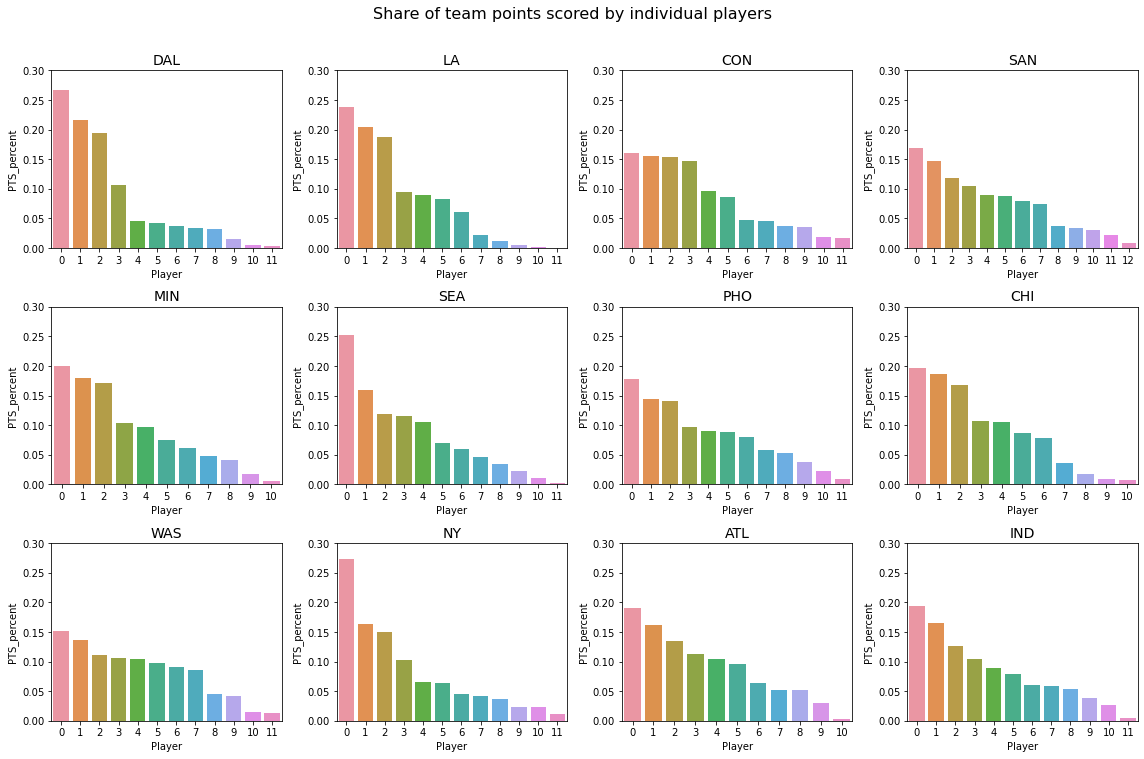

In [6]:
rows = 3
cols = 4

fig, ax = plt.subplots(rows,cols, figsize = (16,10), tight_layout=True)

for row in range(rows):
    for col in range(cols):
        data = wnba_points[wnba_points['Team'] == teams[row*cols+col]].sort_values(by = 'PTS', ascending = False)[['Name','PTS']]
        data['PTS_percent'] = data['PTS'] / sum(data['PTS'])
        data['Player'] = [i for i in range(len(wnba_points[wnba_points['Team'] == teams[row*cols+col]]))]
        sns.barplot(x = 'Player', y = 'PTS_percent', data = data, ax = ax[row, col]).set_title(teams[row*cols+col], fontsize=14)
        ax[row, col].set(ylim=(0, 0.3))
        
plt.suptitle("Share of team points scored by individual players", fontsize = 16, y=1.05)

plt.style.use('ggplot')
plt.show()

In [7]:
px.line(
    data_frame=wnba, 
    x = 'Cumulative number of players', 
    y = 'Cumulative share of points scored', 
    line_group='Team', 
    color = 'Team',
    line_dash ='Season_winner', 
    line_dash_map = {True:'solid', False : 'dot'}, 
    title = 'Minnesota Lynx is the season winner - are they more of an "team effort" team?', 
    labels = {'x':'number of players'}, 
    height = 700, 
    width =900
)


# Minutes played per game 

In [8]:
hist_data = [[el for el in wnba['Minutes played by player per game'][wnba['Team'] == tm]] for tm in teams]

group_labels = teams

# Create distplot with custom bin_size
fig = ff.create_distplot(
    hist_data, 
    group_labels,
    show_rug = False,
    show_hist = False
)

fig.update_layout(title='Team effort - Distribution of minutes played per game per player')

fig.show()

# Simplified player efficiency per 36 minutes played 

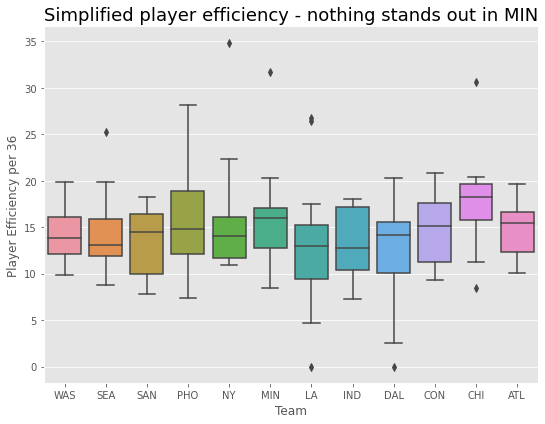

In [18]:
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x = "Team",y = 'Player Efficiency per 36',data=wnba)
plt.title('Simplified player efficiency - nothing stands out in MIN', fontsize = 18)
plt.tight_layout()

# Experience impact

In [9]:
hist_data = [[el for el in wnba['Experience of a player'][wnba['Team'] == tm]] for tm in teams]

group_labels = teams

# Create distplot with custom bin_size
fig = ff.create_distplot(
    hist_data, 
    group_labels,
    show_rug = False,
    show_hist = False
)

fig.update_layout(title='Distribution of experience per team')

fig.show()

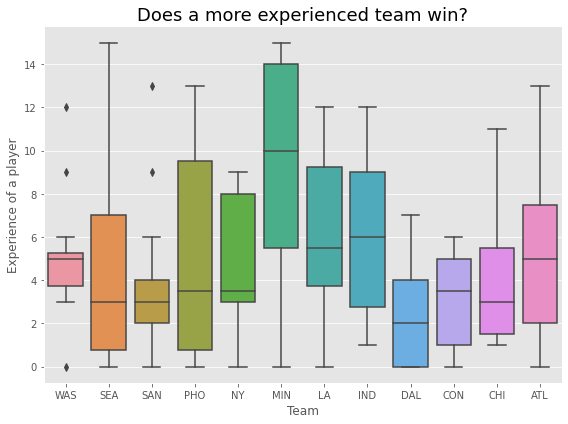

In [20]:
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x="Team",y='Experience of a player',data=wnba)
plt.title('Does a more experienced team win?', fontsize = 18)
plt.tight_layout()

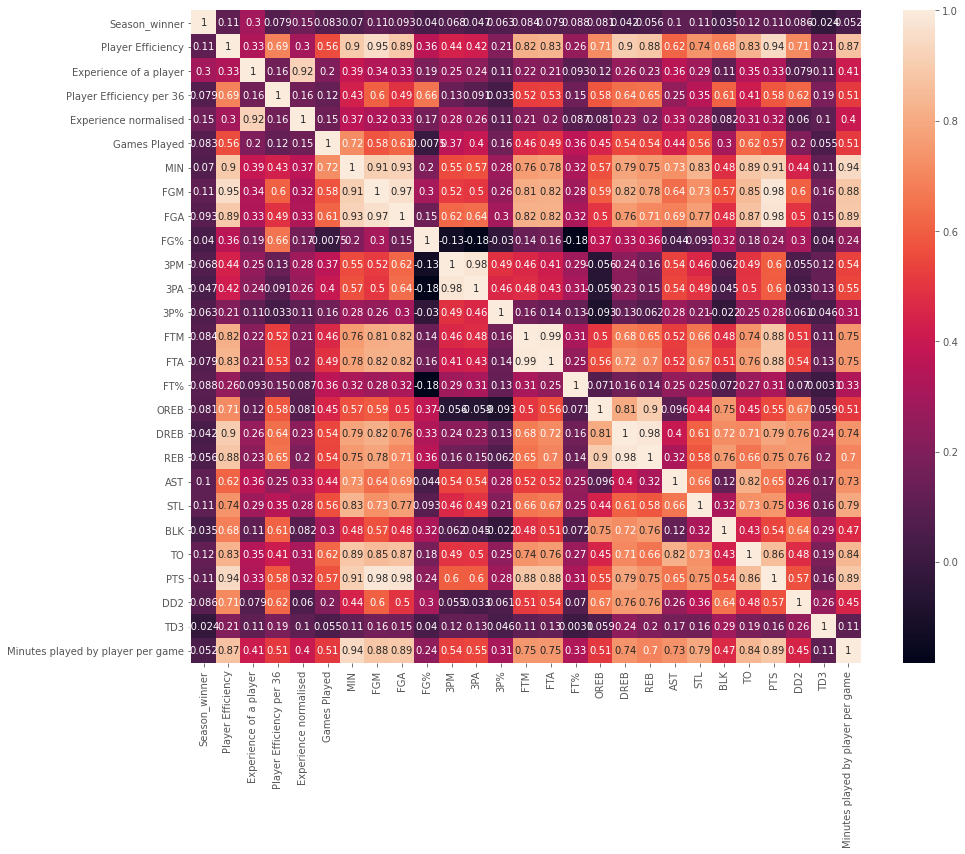

In [12]:
plt.figure(figsize=(15,12))
sns.heatmap(wnba[['Season_winner', "Player Efficiency", 'Experience of a player',"Player Efficiency per 36", 'Experience normalised', 'Games Played', 'MIN',
       'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PTS', 'DD2', 'TD3',
       'Minutes played by player per game']].corr(), annot = True)

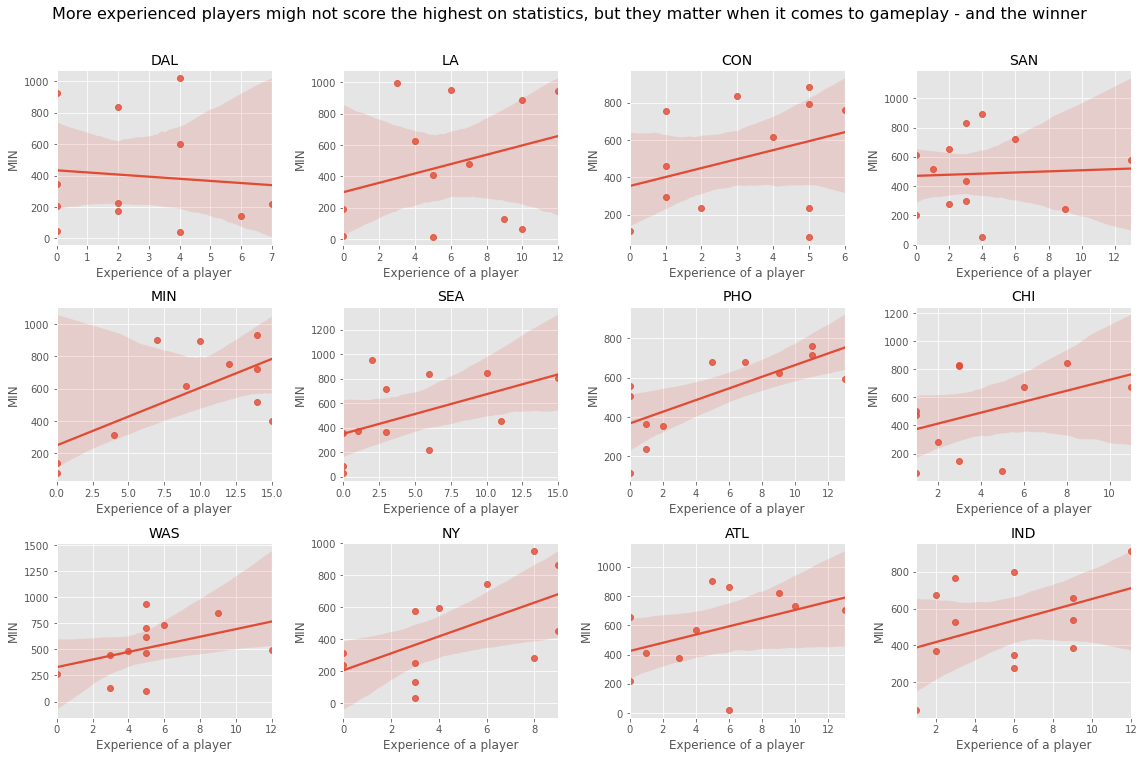

In [13]:
rows = 3
cols = 4

fig, ax = plt.subplots(rows,cols, figsize = (16,10), tight_layout=True)

y = 'MIN'

for row in range(rows):
    for col in range(cols):
        sns.regplot(
            x = 'Experience of a player', 
            y = y, 
            data = wnba[wnba['Team'] == teams[row*cols+col]], 
            ax = ax[row, col],
            fit_reg = True
        ).set_title(teams[row*cols+col], fontsize=14)
        
plt.suptitle("More experienced players migh not score the highest on statistics, but they matter when it comes to gameplay - and the winner ", fontsize = 16, y=1.05)

plt.style.use('ggplot')
plt.show()

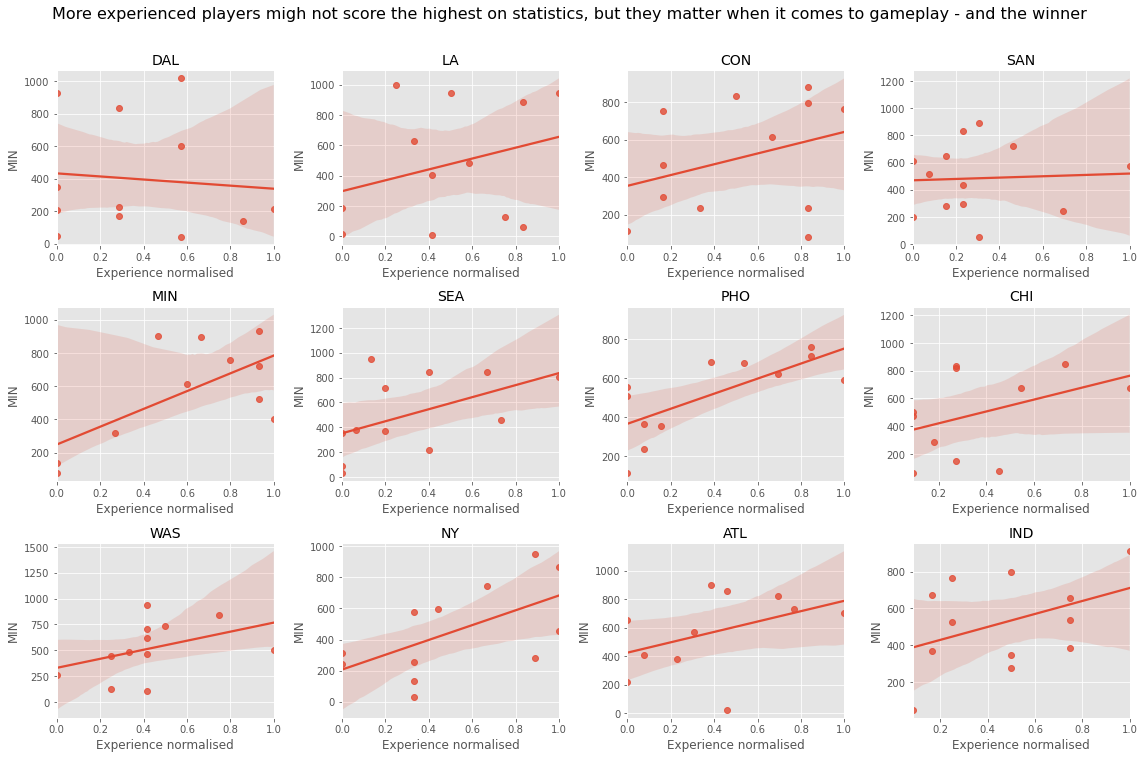

In [14]:
rows = 3
cols = 4

fig, ax = plt.subplots(rows,cols, figsize = (16,10), tight_layout=True)

y = 'MIN'

for row in range(rows):
    for col in range(cols):
        sns.regplot(
            x = 'Experience normalised', 
            y = y, 
            data = wnba[wnba['Team'] == teams[row*cols+col]], 
            ax = ax[row, col],
            fit_reg = True
        ).set_title(teams[row*cols+col], fontsize=14)
        
plt.suptitle("More experienced players migh not score the highest on statistics, but they matter when it comes to gameplay - and the winner ", fontsize = 16, y=1.05)

plt.style.use('ggplot')
plt.show()

# Ofensive rebound vs defensive rebounds 

In [15]:
hist_data = [[el for el in wnba['OREB_v_DREB'][wnba['Team'] == tm]] for tm in teams]

group_labels = teams

# Create distplot with custom bin_size
fig = ff.create_distplot(
    hist_data, 
    group_labels,
    show_rug = False,
    show_hist = False
)

fig.update_layout(title='Distribution of Offencive Rebound to Defensive Rebound ratio')

fig.show()

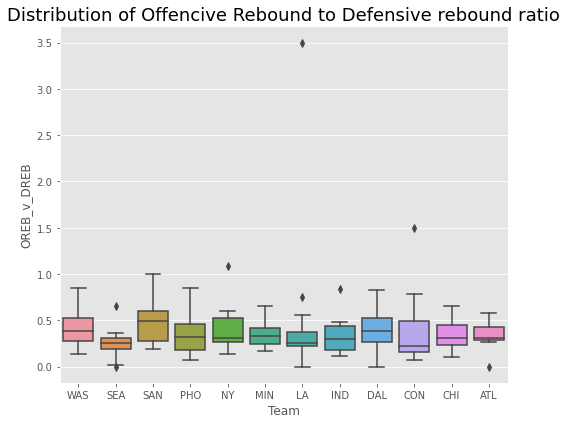

In [19]:
fig,ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(x = "Team",y = 'OREB_v_DREB',data=wnba)
plt.title('Distribution of Offencive Rebound to Defensive rebound ratio', fontsize = 18)
plt.tight_layout()